<center>
<h1 style="color:red; font-size:70px;"> Simple CNN</h1>

In questo jupiter notebook è presente un semplice esempio di CNN classifier, il cui obiettivo è quello di riconoscere se le radiografie polmonari di alcuni pazienti evidenziano l'infezione da COVID-19 oppure no. Il dataset in uso è stato scaricato da Kaggle al seguente link: https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets?resource=download.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Rescaling, MaxPooling2D, Conv2D, Dropout

2025-08-27 19:10:36.881352: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-27 19:10:36.903667: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-27 19:10:36.985598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756314637.119720   21357 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756314637.135801   21357 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756314637.239806   21357 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Costruzione del dataset

In questo spezzone di codice viene preparato il dataset di immagini perché possa essere utilizzato in maniera semplice da una rete neurale convoluzionale. Per prima cosa viene specificato dove si trovano i le immagini; viene fornito solo il nome della cartella madre, perchè le sottocartelel saranno interpretate come le varie classi. Una volta normalizzati i valori dei pixels, si utilizza la funzione ***flow_from_directory*** per leggere le immagini e ridimensionarle alla size desiderata. Inoltre, dato che viene specificata una batch size di 32, le immagini non vengono caricate tutte insieme in memoria, ma elaborate a piccoli gruppi.

In [7]:
# Raccoglie le varie classi, che avranno come nome quello delle sotto-cartelle
dataset_dir = "Datasets/satellite"  

# Generatore con split per validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

# Dataset di training
trDat = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=64,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Dataset di validation
valDat = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=64,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


## Costruzione del modello

Le reti neurali convoluzionali (CNN, Convolutional Neural Networks) prendono il loro nome dal fatto che il loro elemento fondamentale è l’operazione di convoluzione. In altre parole, invece di collegare ogni neurone a tutti i pixel di un’immagine come nelle reti dense tradizionali, le CNN applicano filtri (kernel) piccoli che scorrono sull’immagine per rilevare caratteristiche locali come bordi, angoli, texture o pattern specifici.

Questa logica è proprio quella implementata nella funzione ***buildMod***, il cui obiettivo è quello di restituire un modello che consenta un'analisi accurata delle immagini con conseguente classificazione.

In [8]:
# Funzione per costruire il modello in questione
def builMod(imH, imW, numcl):

    model = keras.Sequential()
    model.add(Input(shape=(imH, imW, 3)))
    # Per i layer convoluzionali utilizzaimo Conv2D, che crea un kernel convoluzionale che è in 
    # convoluzione con l'input su uno spazio 2D (larghezza e lunghezza). In particolare specifichiamo:
    #
    # filters --> il numero di filtri da applicare. Ogni filtro si dedica all'individuazione di 
    # una caratteristica differente, quindi "più filtri == più caratteristiche 
    # imparate"
    #
    # kernel_size --> specifica le dimensioni del filtro, quindi larghezza ed altezza
    #
    # Si possono anche specificare altri parametri quali la funzione d'attivazione
    model.add(Conv2D(16, (3, 3), activation = 'relu'))
    # Dopo uno strato convozionale introduciamo un layer di pooling, il cui scopo è quello di 
    # rendere più efficiente la rete neurale, dato che la dimensione delle immagini vinee ridotta, 
    # mantenendo tuttavia le caratteristiche principali. Questo vuol dire che le successive analisi 
    # saranno più immmediate. Un parametro importante da segnalare è il "pool_size", che definisce 
    # le dimensioni della finestra di campionamento
    model.add(MaxPooling2D((2, 2)))
    # Per rendere lo studio dell'immagine più accurato inserisco altri layer convoluzionali e di 
    # pooling, in modo da caratterizzare altre features
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))

    # Inizia ora la parte fully connected per la classificazione delle immagini
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numcl, activation = 'softmax'))
    
    return model

# Costruzione del modello ed allenamento della rete (uso categorical_crossentropy perchè ho classi
# riportate in one-hot encoding)
model = builMod(128, 128, 4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

## Allenamento del modello

In [11]:
hist = model.fit(trDat, epochs=15, validation_data=valDat)

Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.6712 - loss: 0.5765 - val_accuracy: 0.8535 - val_loss: 0.3738
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8325 - loss: 0.3831 - val_accuracy: 0.8055 - val_loss: 0.4603
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8710 - loss: 0.3199 - val_accuracy: 0.7513 - val_loss: 0.4718
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8646 - loss: 0.3382 - val_accuracy: 0.8055 - val_loss: 0.4693
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8829 - loss: 0.2867 - val_accuracy: 0.7771 - val_loss: 0.4370
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8753 - loss: 0.3014 - val_accuracy: 0.8970 - val_loss: 0.2278
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8783 - loss: 0.3019 - val_accuracy: 0.8828 - val_loss: 0.2764
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8923 - loss: 0.2622 - val_accuracy: 0.8934 - v

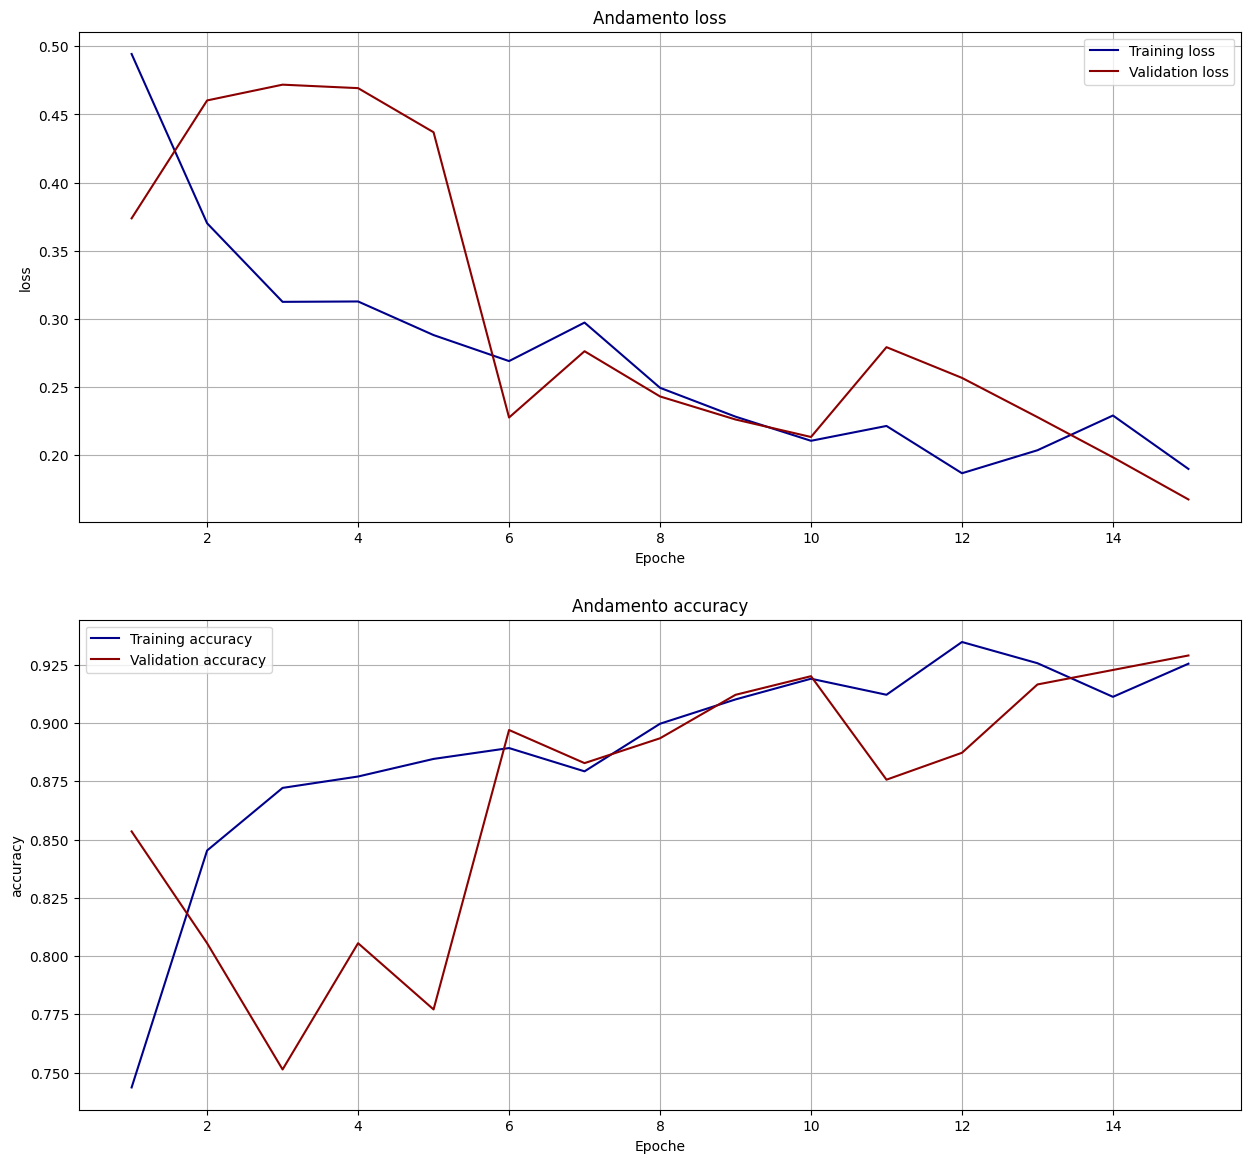

In [12]:
def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    dim = len(hist.history['loss'])
    lab = ['loss', 'accuracy']

    for i, l in enumerate(lab):
        ax[i].plot(np.linspace(1, dim, dim), hist.history[l], color = 'darkblue', label = "Training " + l)
        ax[i].plot(np.linspace(1, dim, dim), hist.history['val_'+l], color = 'darkred', label = "Validation " + l)
        ax[i].set_title("Andamento " + l)
        ax[i].set_xlabel("Epoche")
        ax[i].set_ylabel(l)

        ax[i].legend(loc="best")
        ax[i].grid(True)
    plt.show()
    
plotTrInfo(hist)